<a href="https://colab.research.google.com/github/maimonahST/ComputerVisionLabs/blob/main/Project/CV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leapgestrecog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F39466%2F61155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T212046Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2dd5ffcc3ccfc33bc060b18147b2312756ecc3af8f3dcef81f5d72507203751f028bf381c488eeca30f4368c3222fbef614ba0a0fc0c963fa2c4f6b8c7ff7ffbd811aab2415b0b36405bd24b7990d140c9516d37e350f3642285329d6189dd64ffba42ced1f4b90bb5070f12ab0ee9dd3b3c14714ba1657fd489872565fb158d83e40a3f52757ace46119735828f2d1f334ff12fa7b0a5deb4a4cd4ff29f6ebf12b6fa146b439fee1a4331ab9981aa4bec56d7f58344196ada527adf7b7ed329a2fcaa63cbacddbbbc10ffc68003fb19987a32e3907fe322c03be1306e94b3224559b8a105ff7b91153025fb5da14070185ab9e50233dd6498a11bdcc3bf4a45,mobilenet-v2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5016327%2F8424793%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T212046Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9d77eff8c86711918df0809d1224ab4207905f9cfadf082b0663765dbdf20d454294227b3b1e28cc56e812dff4533acacde24fc05b376a6a61aa0b0b240b2c09b570b7ea5f28f3faec5253649e128e1faeee62c9907e2dca29134d32858eaa9c005a84b17bc99ae04df7e9b0b06c66b6d03899f9681c7593dba3632f17bb1ee754045c17c1852092b3e6835d12ff372276cd37602e8d0cbe5e69a1bcdc37204a0533a7e9a1e3780060b018c83ecb62e8164bedbeb9d5f852660b85f467cc850015ef82b2562de5f1e09948684c5e2b7e8c1493214f7b59b5c82940d781ada55fb806a5540f8aa1318b6c56cc19bbe2cce0da69590b3cb022a14a33c7dc54b009'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2286085038 bytes downloaded
Downloaded and uncompressed: leapgestrecog
[==================================================] 8442202 bytes downloaded
Downloaded and uncompressed: mobilenet-v2
Data source import complete.


# Define Functions

In [2]:
import os
import numpy as np
import pandas as pd
import cv2

# Function to load data
def load_data_path(target_classes, dataset_path):
    X = []
    y = []
    # Iterate over inner folders
    for inner_folder in os.listdir(dataset_path):
        inner_folder_path = os.path.join(dataset_path, inner_folder)
        if os.path.isdir(inner_folder_path):
            # Iterate over target classes within each inner folder
            for label, gesture in enumerate(target_classes):
                gesture_dir = os.path.join(inner_folder_path, gesture)
                if os.path.isdir(gesture_dir):
                    for root, _, files in os.walk(gesture_dir):
                        for file in files:
                            if file.endswith('.png'):
                                file_path = os.path.join(root, file)
                                X.append(file_path)
                                y.append(label)
    return X, y


# Function to preprocess images
def preprocess_image(file_path):
    image = cv2.imread(file_path)
    resized_image = cv2.resize(image, (250, 250), interpolation=cv2.INTER_AREA)
    resized_image[resized_image < 90] = 255
    blur_image = cv2.GaussianBlur(resized_image, (7, 7), 0)
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened_image = cv2.filter2D(blur_image, -1, kernel)
    return sharpened_image



# Function to save images in respective directories
def save_images(X, y, dataset_type):
    for num, (img, label) in enumerate(zip(X, y)):
        label_dir = os.path.join(base_dir, f'images/{dataset_type}/{target_classes[label]}')
        os.makedirs(label_dir, exist_ok=True)
        save_path = os.path.join(label_dir, f'img{num}.png')
        cv2.imwrite(save_path, img)



# Function to load images from a directory
def load_images_from_dir(directory, target_classes, target_size=(250, 250)):
    images = []
    labels = []
    for label, class_name in enumerate(target_classes):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                image = cv2.imread(file_path)
                image = cv2.resize(image, target_size)
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)


def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

# First Experement :
### Binary Classification (First, OK)

## Preprocessing

In [ ]:
# Define the path to the dataset
dataset_path = '/kaggle/input/leapgestrecog/leapGestRecog/'

# Define the target classes
target_classes = ['03_fist', '07_ok']

# Load the data
X, y = load_data_path(target_classes, dataset_path)

In [ ]:
# print the leangth of X and y
print(len(X), len(y))

4000 4000


In [ ]:
# print the unique values of y
unique_labels = set(y)
print("Unique values of y:", unique_labels)

Unique values of y: {0, 1}


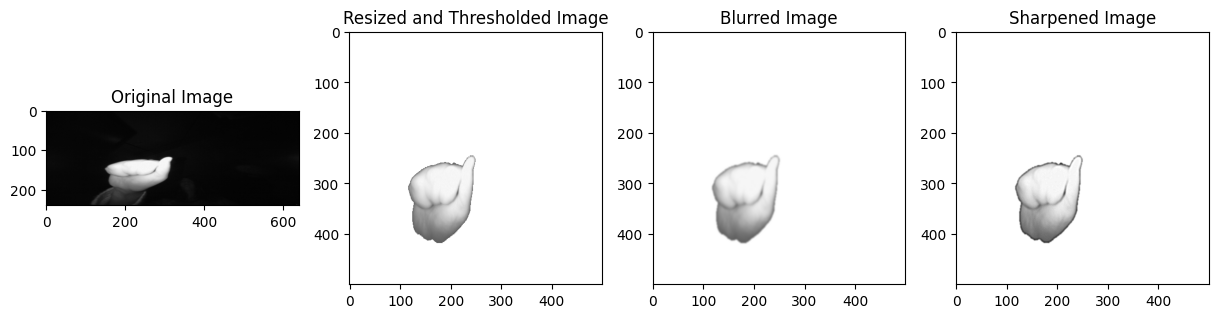

In [ ]:
# sample

# Print one sample image after each step
sample_image_path = X[0]
original_image = cv2.imread(sample_image_path)
resized_image = cv2.resize(original_image, (500, 500), interpolation=cv2.INTER_AREA)
resized_image[resized_image < 90] = 255
blur_image = cv2.GaussianBlur(resized_image, (7, 7), 0)
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened_image = cv2.filter2D(blur_image, -1, kernel)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Resized and Thresholded Image')
plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(blur_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image')
plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.title('Sharpened Image')
plt.show()

In [ ]:
# Preprocess all images
processed_images = []
for file_path in X:
    processed_images.append(preprocess_image(file_path))


len(processed_images)

4000

## Split the data

In [ ]:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Convert lists to numpy arrays
processed_images = np.array(processed_images)
y = np.array(y)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(processed_images, y, test_size=0.3, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.6666, stratify=y_temp) # 20% of the original dataset



In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

X_train.shape, X_valid.shape , X_test.shape

((2800, 250, 250, 3), (400, 250, 250, 3), (800, 250, 250, 3))

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

y_train.shape, y_valid.shape , y_test.shape

((2800,), (400,), (800,))

In [ ]:
# Create directories
base_dir = '/kaggle/working/Binary'
os.makedirs(f'{base_dir}/images/train/', exist_ok=True)
os.makedirs(f'{base_dir}/images/val/', exist_ok=True)
os.makedirs(f'{base_dir}/images/test/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/train/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/val/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/test/', exist_ok=True)


# Save preprocessed images for training, validation, and testing
save_images(X_train, y_train, 'train')
save_images(X_valid, y_valid, 'val')
save_images(X_test, y_test, 'test')

## Model Bulding

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the target classes
target_classes = ['03_fist', '07_ok']

# Define model name and handle
model_name = "mobilenet_v2_140_224"
model_handle_map = {
    "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}
model_image_size_map = {
    "mobilenet_v2_140_224": 224,
}
model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16  # Reduced batch size to conserve memory

# Create the base model from the pre-trained convnets
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Build the model
do_fine_tuning = True
print("Building model with", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    Dropout(rate=0.3),
    Dense(len(target_classes), activation='softmax',  # Change to 'softmax' for multi-class classification
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,) + IMAGE_SIZE + (3,))
model.summary()

# Compile the model
model.compile(loss='binary_crossentropy',  # Change to 'categorical_crossentropy' for multi-class classification
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Define base directory
base_dir = '/kaggle/working/Binary/images'

# Train generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
)



Selected model: mobilenet_v2_140_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1792)              4363712   
                                                                 
 dropout_2 (Dropout)         (None, 1792)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 3586      
                                                                 
Total params: 4367298 (16.66 MB)
Trainable params: 4319362 (16.48 MB)
Non-trainable params: 47936 (187.25 KB)
_________________________________________________________________
Found 2800 images belonging to 2 classes.
Found 400 images belonging to

## Model Evaluation

In [ ]:
# Test generator
test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

Found 800 images belonging to 2 classes.
50/50 - 2s - loss: 0.0883 - accuracy: 1.0000 - 2s/epoch - 36ms/step
Test accuracy: 1.0


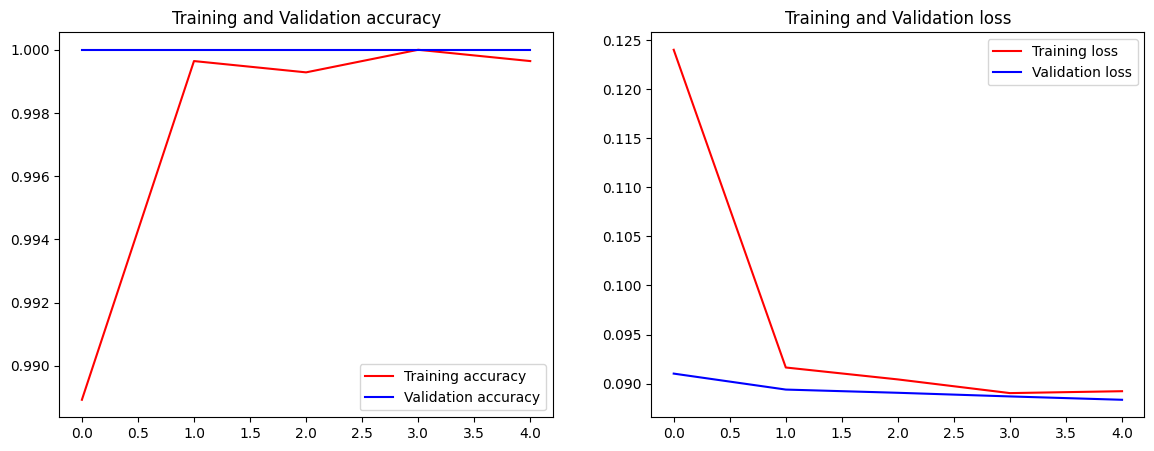

In [ ]:
plot_training_history(history)

50/50 [==============================] - 5s 62ms/step


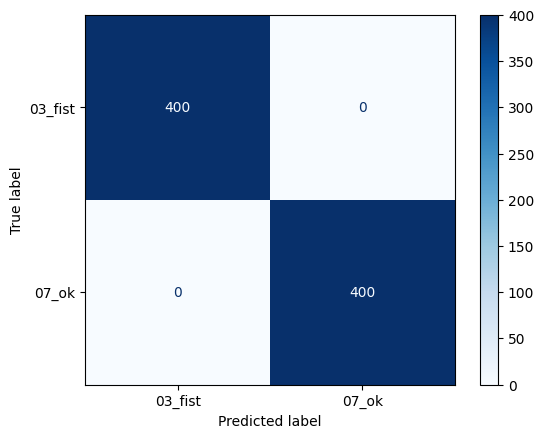

In [ ]:
# Print the confusion matrix

print_confusion_matrix(model, test_generator)


In [ ]:
from sklearn.metrics import classification_report

# Generate and print classification report
def print_classification_report(model, test_generator):
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    y_true = test_generator.classes
    report = classification_report(y_true, y_pred, target_names=target_classes)
    print(report)

print_classification_report(model, test_generator)

50/50 [==============================] - 2s 42ms/step
              precision    recall  f1-score   support

     03_fist       1.00      1.00      1.00       400
       07_ok       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



# Second Experement :
### Multicalss Classification (First, OK, C)

## Preprocessing

In [ ]:
# Define the path to the dataset
dataset_path = '/kaggle/input/leapgestrecog/leapGestRecog/'

# Define the target classes
target_classes = ['03_fist', '07_ok', '09_c']

# Load the data
X, y = load_data_path(target_classes, dataset_path)

In [ ]:
# print the leangth of X and y
print(len(X), len(y))

6000 6000


In [ ]:
# print the unique values of y
unique_labels = set(y)
print("Unique values of y:", unique_labels)

Unique values of y: {0, 1, 2}


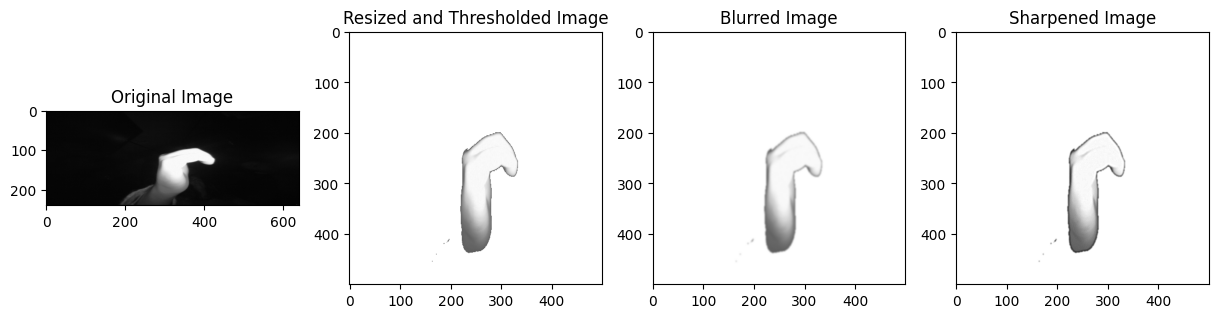

In [ ]:
# sample
# Plot the training history
import matplotlib.pyplot as plt

# Print one sample image after each step
sample_image_path = X[500]
original_image = cv2.imread(sample_image_path)
resized_image = cv2.resize(original_image, (500, 500), interpolation=cv2.INTER_AREA)
resized_image[resized_image < 90] = 255
blur_image = cv2.GaussianBlur(resized_image, (7, 7), 0)
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened_image = cv2.filter2D(blur_image, -1, kernel)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Resized and Thresholded Image')
plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(blur_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image')
plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.title('Sharpened Image')
plt.show()

In [ ]:
# Preprocess all images
processed_images = []
for file_path in X:
    processed_images.append(preprocess_image(file_path))


len(processed_images)

6000

## Split the data

In [ ]:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Convert lists to numpy arrays
processed_images = np.array(processed_images)
y = np.array(y)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(processed_images, y, test_size=0.3, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.6666, stratify=y_temp) # 20% of the original dataset



In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

X_train.shape, X_valid.shape , X_test.shape

((4200, 250, 250, 3), (600, 250, 250, 3), (1200, 250, 250, 3))

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

y_train.shape, y_valid.shape , y_test.shape

((4200,), (600,), (1200,))

In [ ]:
# Create directories
base_dir = '/kaggle/working/Three_classes'
os.makedirs(f'{base_dir}/images/train/', exist_ok=True)
os.makedirs(f'{base_dir}/images/val/', exist_ok=True)
os.makedirs(f'{base_dir}/images/test/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/train/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/val/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/test/', exist_ok=True)


# Save preprocessed images for training, validation, and testing
save_images(X_train, y_train, 'train')
save_images(X_valid, y_valid, 'val')
save_images(X_test, y_test, 'test')

In [ ]:
import os
import cv2
import numpy as np

# Define the target classes
target_classes = ['03_fist', '07_ok', '09_c']

# Define base directory
base_dir = '/kaggle/working/your-dataset'

# Load images from directories
X_train, y_train = load_images_from_dir(os.path.join(base_dir,target_classes, 'images/train'))
X_valid, y_valid = load_images_from_dir(os.path.join(base_dir,target_classes, 'images/val'))
X_test, y_test = load_images_from_dir(os.path.join(base_dir,target_classes, 'images/test'))

## Model Bulding

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the target classes
target_classes = ['03_fist', '07_ok', '09_c']

# Define model name and handle
model_name = "mobilenet_v2_140_224"
model_handle_map = {
    "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}
model_image_size_map = {
    "mobilenet_v2_140_224": 224,
}
model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16  # Reduced batch size to conserve memory

# Create the base model from the pre-trained convnets
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Build the model
do_fine_tuning = True
print("Building model with", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    Dropout(rate=0.3),
    Dense(len(target_classes), activation='softmax',  # Change to 'softmax' for multi-class classification
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,) + IMAGE_SIZE + (3,))
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',  # Change to 'categorical_crossentropy' for multi-class classification
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Define base directory
base_dir = '/kaggle/working/Three_classes/images'

# Train generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)



Selected model: mobilenet_v2_140_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1792)              4363712   
                                                                 
 dropout_1 (Dropout)         (None, 1792)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 5379      
                                                                 
Total params: 4369091 (16.67 MB)
Trainable params: 4321155 (16.48 MB)
Non-trainable params: 47936 (187.25 KB)
_________________________________________________________________
Found 4200 images belonging to 3 classes.
Found 600 images belonging to

## Model Evaluation

Found 1200 images belonging to 3 classes.
75/75 - 4s - loss: 0.0858 - accuracy: 1.0000 - 4s/epoch - 55ms/step
Test accuracy: 1.0


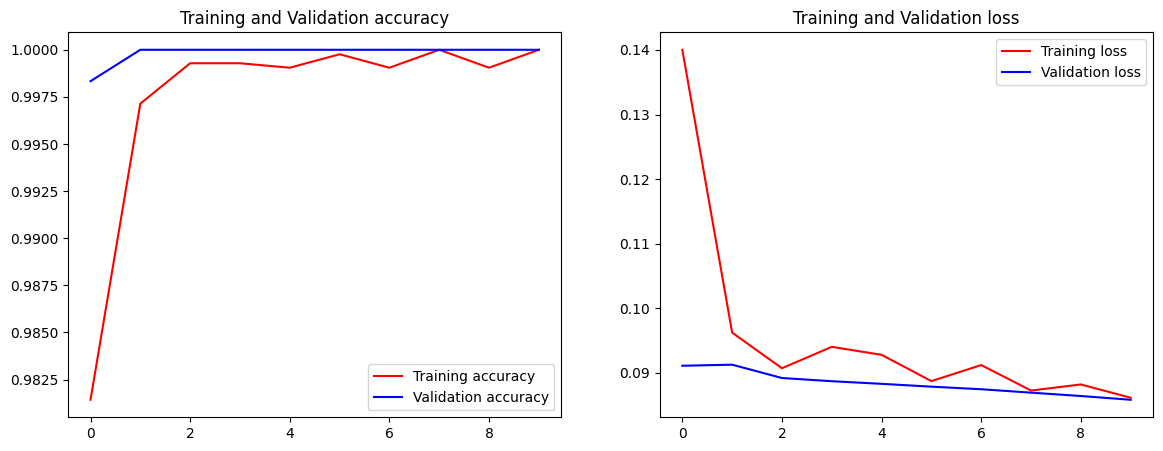

In [ ]:
# Test generator
test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

plot_training_history(history)

75/75 [==============================] - 3s 39ms/step


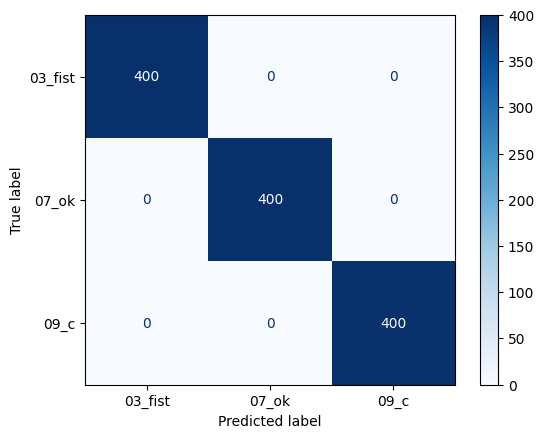

In [ ]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def print_confusion_matrix(model, test_generator):
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    y_true = test_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

print_confusion_matrix(model, test_generator)


In [ ]:
from sklearn.metrics import classification_report

# Generate and print classification report
def print_classification_report(model, test_generator):
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    y_true = test_generator.classes
    report = classification_report(y_true, y_pred, target_names=target_classes)
    print(report)

print_classification_report(model, test_generator)

75/75 [==============================] - 3s 37ms/step
              precision    recall  f1-score   support

     03_fist       1.00      1.00      1.00       400
       07_ok       1.00      1.00      1.00       400
        09_c       1.00      1.00      1.00       400

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



# Third Experement :
### Multicalss Classification (First, OK, C, )

## Preprocessing

In [ ]:
# Define the path to the dataset
dataset_path = '/kaggle/input/leapgestrecog/leapGestRecog/'

# Define the target classes
target_classes = ['01_palm', '03_fist', '07_ok', '09_c', '10_down']

# Load the data
X, y = load_data_path(target_classes, dataset_path)

In [ ]:
# print the leangth of X and y
print(len(X), len(y))

10000 10000


In [ ]:
# print the unique values of y
unique_labels = set(y)
print("Unique values of y:", unique_labels)

Unique values of y: {0, 1, 2, 3, 4}


In [ ]:
# Preprocess all images
processed_images = []
for file_path in X:
    processed_images.append(preprocess_image(file_path))


len(processed_images)

10000

## Split the data

In [ ]:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Convert lists to numpy arrays
processed_images = np.array(processed_images)
y = np.array(y)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(processed_images, y, test_size=0.3, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.6666, stratify=y_temp) # 20% of the original dataset



In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

X_train.shape, X_valid.shape , X_test.shape

((7000, 250, 250, 3), (1000, 250, 250, 3), (2000, 250, 250, 3))

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

y_train.shape, y_valid.shape , y_test.shape

((7000,), (1000,), (2000,))

In [ ]:
# Create directories
base_dir = '/kaggle/working/Five_classes'
os.makedirs(f'{base_dir}/images/train/', exist_ok=True)
os.makedirs(f'{base_dir}/images/val/', exist_ok=True)
os.makedirs(f'{base_dir}/images/test/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/train/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/val/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/test/', exist_ok=True)


# Save preprocessed images for training, validation, and testing
save_images(X_train, y_train, 'train')
save_images(X_valid, y_valid, 'val')
save_images(X_test, y_test, 'test')

## Model Bulding

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the target classes
target_classes = ['01_palm', '03_fist', '07_ok', '09_c', '10_down']

# Define model name and handle
model_name = "mobilenet_v2_140_224"
model_handle_map = {
    "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}
model_image_size_map = {
    "mobilenet_v2_140_224": 224,
}
model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16  # Reduced batch size to conserve memory

# Create the base model from the pre-trained convnets
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Build the model
do_fine_tuning = True
print("Building model with", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    Dropout(rate=0.3),
    Dense(len(target_classes), activation='softmax',  # Change to 'softmax' for multi-class classification
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,) + IMAGE_SIZE + (3,))
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',  # Change to 'categorical_crossentropy' for multi-class classification
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Define base directory
base_dir = '/kaggle/working/Five_classes/images'

# Train generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)



Selected model: mobilenet_v2_140_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
9406464/9406464 [==============================] - 0s 0us/step
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1792)              4363712   
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 5)                 8965      
                                                                 
Total params: 4372677 (16.68 MB)
Trainable params: 4324741 (16.50 MB)
Non-trainable params: 47936 (187.25 KB)
_________________________________________________________________
Found 7000

## Model Evaluation

Found 2000 images belonging to 5 classes.
125/125 - 11s - loss: 0.0834 - accuracy: 1.0000 - 11s/epoch - 87ms/step
Test accuracy: 1.0


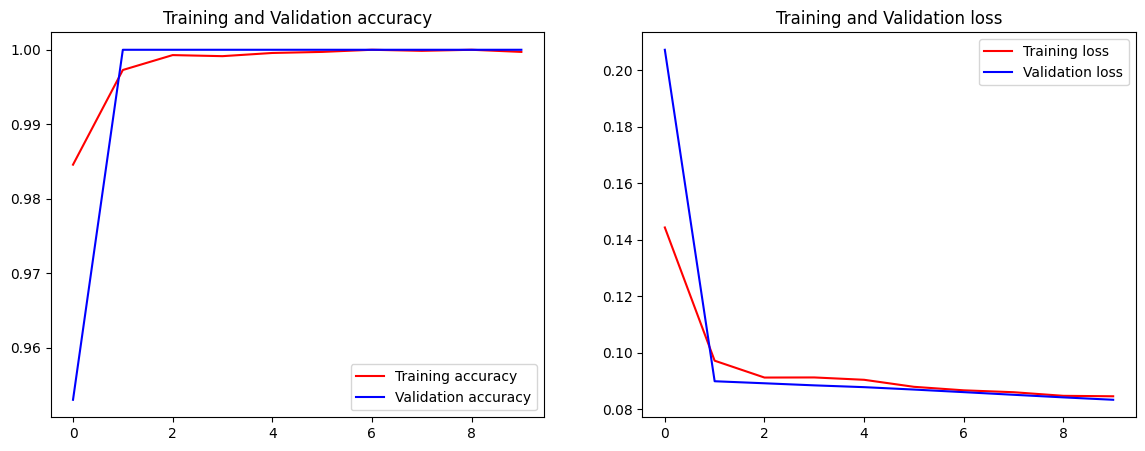

In [ ]:
# Test generator
test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

plot_training_history(history)

125/125 [==============================] - 5s 35ms/step


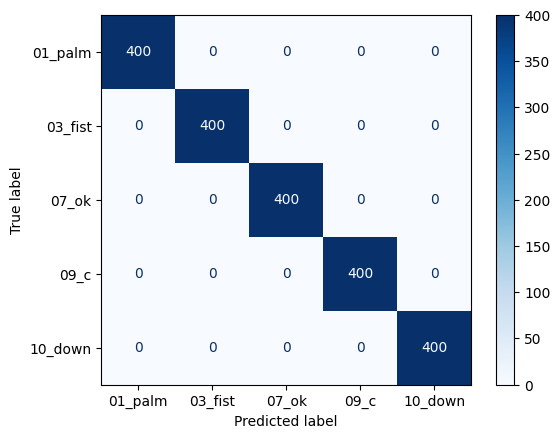

In [ ]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def print_confusion_matrix(model, test_generator):
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    y_true = test_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

print_confusion_matrix(model, test_generator)


In [ ]:
from sklearn.metrics import classification_report

# Generate and print classification report
def print_classification_report(model, test_generator):
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    y_true = test_generator.classes
    report = classification_report(y_true, y_pred, target_names=target_classes)
    print(report)

print_classification_report(model, test_generator)

125/125 [==============================] - 4s 36ms/step
              precision    recall  f1-score   support

     01_palm       1.00      1.00      1.00       400
     03_fist       1.00      1.00      1.00       400
       07_ok       1.00      1.00      1.00       400
        09_c       1.00      1.00      1.00       400
     10_down       1.00      1.00      1.00       400

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



# Fourth Experement :
### Multicalss Classification (Palm, L ,Fist, Fist_moved,Thumb, Index, Ok,Palm_moved, C, Down)

## Preprocessing

In [3]:
# Define the path to the dataset
dataset_path = '/kaggle/input/leapgestrecog/leapGestRecog/'

# Define the target classes
target_classes = ['01_palm','02_l' ,'03_fist','04_fist_moved','05_thumb', '06_index', '07_ok','08_palm_moved', '09_c', '10_down']

# Load the data
X, y = load_data_path(target_classes, dataset_path)

In [4]:
# print the leangth of X and y
print(len(X), len(y))

20000 20000


In [5]:
# print the unique values of y
unique_labels = set(y)
print("Unique values of y:", unique_labels)

Unique values of y: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [6]:
# Preprocess all images
processed_images = []
for file_path in X:
    processed_images.append(preprocess_image(file_path))


len(processed_images)

20000

## Split the data

In [7]:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Convert lists to numpy arrays
processed_images = np.array(processed_images)
y = np.array(y)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(processed_images, y, test_size=0.3, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.6666, stratify=y_temp) # 20% of the original dataset



In [8]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

X_train.shape, X_valid.shape , X_test.shape

((14000, 250, 250, 3), (2000, 250, 250, 3), (4000, 250, 250, 3))

In [9]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

y_train.shape, y_valid.shape , y_test.shape

((14000,), (2000,), (4000,))

In [10]:
# Create directories
base_dir = '/kaggle/working/Ten_classes'
os.makedirs(f'{base_dir}/images/train/', exist_ok=True)
os.makedirs(f'{base_dir}/images/val/', exist_ok=True)
os.makedirs(f'{base_dir}/images/test/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/train/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/val/', exist_ok=True)
os.makedirs(f'{base_dir}/labels/test/', exist_ok=True)


# Save preprocessed images for training, validation, and testing
save_images(X_train, y_train, 'train')
save_images(X_valid, y_valid, 'val')
save_images(X_test, y_test, 'test')

## Model Bulding

In [11]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the target classes
target_classes = ['01_palm','02_l' ,'03_fist','04_fist_moved','05_thumb', '06_index', '07_ok','08_palm_moved', '09_c', '10_down']

# Define model name and handle
model_name = "mobilenet_v2_140_224"
model_handle_map = {
    "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}
model_image_size_map = {
    "mobilenet_v2_140_224": 224,
}
model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16  # Reduced batch size to conserve memory

# Create the base model from the pre-trained convnets
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Build the model
do_fine_tuning = True
print("Building model with", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    Dropout(rate=0.3),
    Dense(len(target_classes), activation='softmax',  # Change to 'softmax' for multi-class classification
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,) + IMAGE_SIZE + (3,))
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',  # Change to 'categorical_crossentropy' for multi-class classification
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Define base directory
base_dir = '/kaggle/working/Ten_classes/images'

# Train generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)



Selected model: mobilenet_v2_140_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
9406464/9406464 [==============================] - 2s 0us/step
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1792)              4363712   
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 10)                17930     
                                                                 
Total params: 4381642 (16.71 MB)
Trainable params: 4333706 (16.53 MB)
Non-trainable params: 47936 (187.25 KB)
_________________________________________________________________
Found 1400

## Model Evaluation

Found 4000 images belonging to 10 classes.
250/250 - 7s - loss: 0.0767 - accuracy: 1.0000 - 7s/epoch - 28ms/step
Test accuracy: 1.0


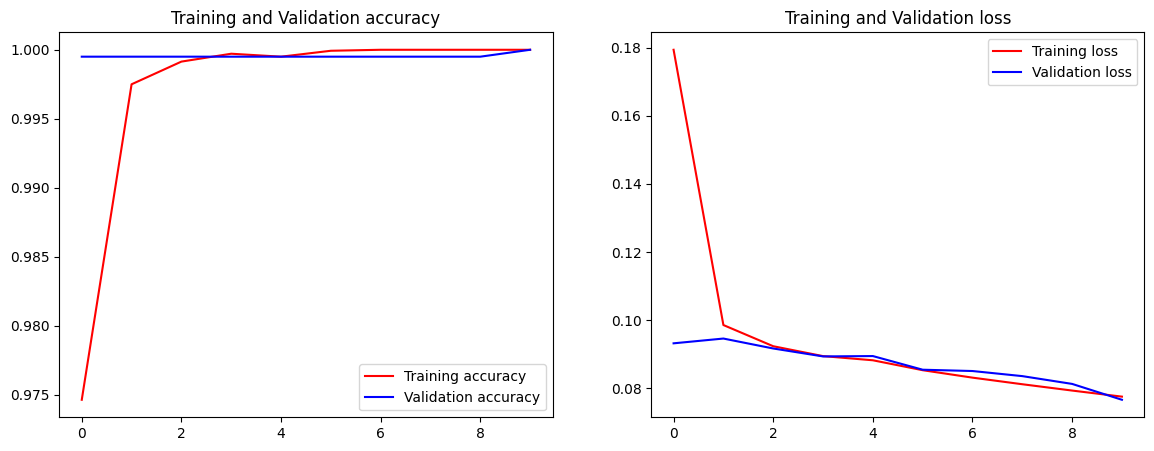

In [13]:
# Test generator
test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

plot_training_history(history)

250/250 [==============================] - 8s 31ms/step


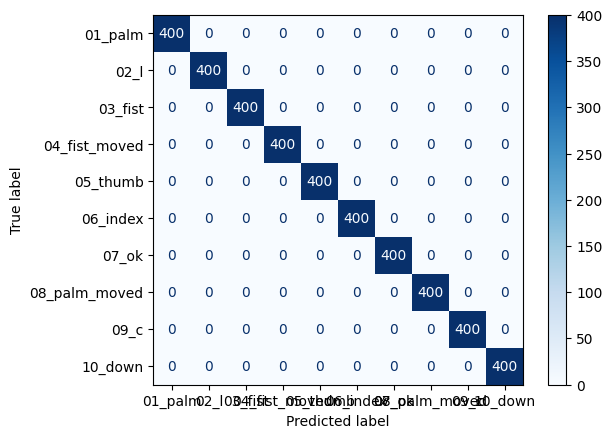

In [14]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def print_confusion_matrix(model, test_generator):
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    y_true = test_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

print_confusion_matrix(model, test_generator)


In [15]:
from sklearn.metrics import classification_report

# Generate and print classification report
def print_classification_report(model, test_generator):
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    y_true = test_generator.classes
    report = classification_report(y_true, y_pred, target_names=target_classes)
    print(report)

print_classification_report(model, test_generator)

250/250 [==============================] - 7s 29ms/step
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       400
         02_l       1.00      1.00      1.00       400
      03_fist       1.00      1.00      1.00       400
04_fist_moved       1.00      1.00      1.00       400
     05_thumb       1.00      1.00      1.00       400
     06_index       1.00      1.00      1.00       400
        07_ok       1.00      1.00      1.00       400
08_palm_moved       1.00      1.00      1.00       400
         09_c       1.00      1.00      1.00       400
      10_down       1.00      1.00      1.00       400

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000

